<a href="https://colab.research.google.com/github/farnazmnz/Brain_Tumor_Detection_Classification/blob/main/BTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Librarys

In [ ]:
import os
import numpy
import matplotlib.pyplot as plt
import h5py
import cv2
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.image
from skimage.transform import resize
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.losses import binary_crossentropy
from keras import backend as K
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import  BatchNormalization
import numpy as np
tf.keras.backend.clear_session()

# **Dataset**

## Upload dataset

In [ ]:
!gdown --id  1IfYSdF3jR9CKQb39Opo-khTCTBHekQvB

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IfYSdF3jR9CKQb39Opo-khTCTBHekQvB
To: /content/BRAIN_DATA-20230730T201920Z-001.zip
100% 880M/880M [00:03<00:00, 253MB/s]


In [ ]:
!unzip BRAIN_DATA-20230730T201920Z-001.zip

Archive:  BRAIN_DATA-20230730T201920Z-001.zip
  inflating: BRAIN_DATA/3055.mat     
  inflating: BRAIN_DATA/3054.mat     
  inflating: BRAIN_DATA/3040.mat     
  inflating: BRAIN_DATA/3060.mat     
  inflating: BRAIN_DATA/3053.mat     
  inflating: BRAIN_DATA/3050.mat     
  inflating: BRAIN_DATA/3062.mat     
  inflating: BRAIN_DATA/3022.mat     
  inflating: BRAIN_DATA/3059.mat     
  inflating: BRAIN_DATA/3052.mat     
  inflating: BRAIN_DATA/3061.mat     
  inflating: BRAIN_DATA/3034.mat     
  inflating: BRAIN_DATA/3033.mat     
  inflating: BRAIN_DATA/3043.mat     
  inflating: BRAIN_DATA/3046.mat     
  inflating: BRAIN_DATA/3063.mat     
  inflating: BRAIN_DATA/3045.mat     
  inflating: BRAIN_DATA/3056.mat     
  inflating: BRAIN_DATA/3047.mat     
  inflating: BRAIN_DATA/3048.mat     
  inflating: BRAIN_DATA/3064.mat     
  inflating: BRAIN_DATA/3042.mat     
  inflating: BRAIN_DATA/3038.mat     
  inflating: BRAIN_DATA/3057.mat     
  inflating: BRAIN_DATA/3049.mat     
  in

## **Data into List**

In [ ]:
# Take All the data into a list
data_dir= '/content/BRAIN_DATA'
total_image=3064
datalist=[]
for i in range(1,total_image+1):
  filename=str(i)+".mat"
  data=h5py.File(os.path.join(data_dir,filename),"r")
  datalist.append(data)

  if i%100==0:
    print(filename)

100.mat
200.mat
300.mat
400.mat
500.mat
600.mat
700.mat
800.mat
900.mat
1000.mat


# **Data Analysis**

In [ ]:
labels=[]


for i  in range(total_image):
  lb=int(datalist[i]["cjdata"]["label"][()])-1

  labels.append(lb)

labels=np.array(labels)
print(labels.shape)

(3064,)


[ 708 1426  930]


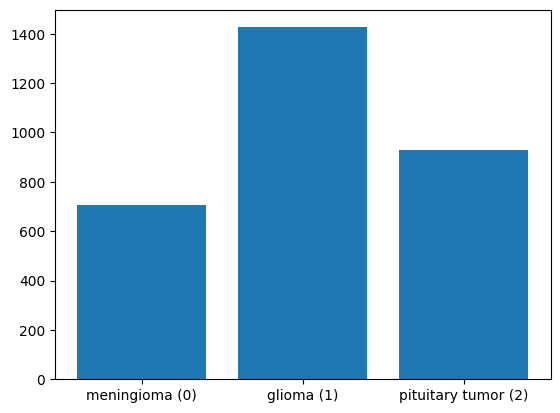

In [ ]:
integer_to_class = {'0': 'meningioma (0)', '1': 'glioma (1)', '2': 'pituitary tumor (2)'}
classes, counts = np.unique(labels,return_counts=True)
plt.bar(classes,counts,tick_label=list(integer_to_class.values()))
print(counts)

# ***Segmentation**

In [ ]:
total_image=3064

### Masks

In [ ]:
masks = []
for i in range(total_image):
  mask = datalist[i]["cjdata"]["tumorMask"][()]
  mask = np.expand_dims(resize(mask, (128, 128), mode="constant", preserve_range=True), axis=-1)
  masks.append(mask)

print(len(masks))

3064


In [ ]:
masks=np.array(masks)
print(masks.shape)

(3064, 128, 128, 1)




### MRI-images

In [ ]:
images = []
for i in range(total_image):
  im = datalist[i]["cjdata"]["image"][()]
  im = np.expand_dims(resize(im, (128, 128), mode="constant", preserve_range=True), axis=-1)
  images.append(im)

print(len(images))


3064


In [ ]:
images=np.array(images)
print(images.shape)

(3064, 128, 128, 1)


### Show image and its mask

Text(0.5, 1.0, 'Mask')

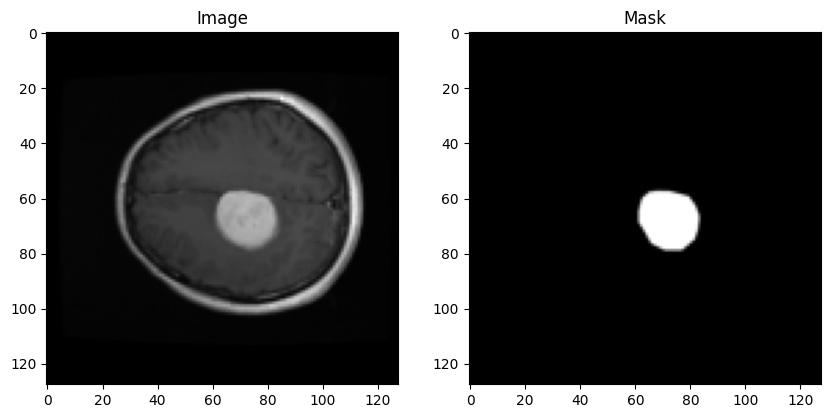

In [ ]:
fig, arr = plt.subplots(1,2,figsize=(10, 10))
arr[0].imshow(images[10],cmap='gray')
arr[0].set_title('Image')
arr[1].imshow(masks[10],cmap='gray')
arr[1].set_title('Mask')

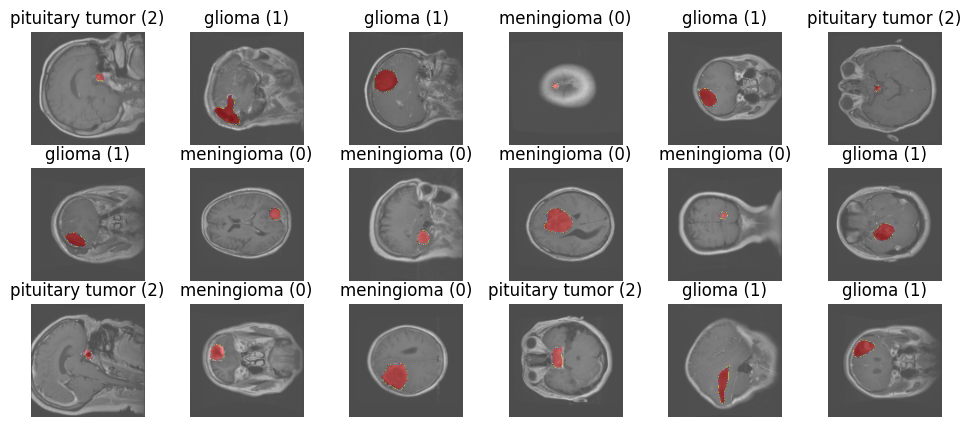

In [ ]:
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(3064, size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow( images[idx], cmap='gray')
    plt.imshow( np.ones_like(masks[idx])-masks[idx], alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

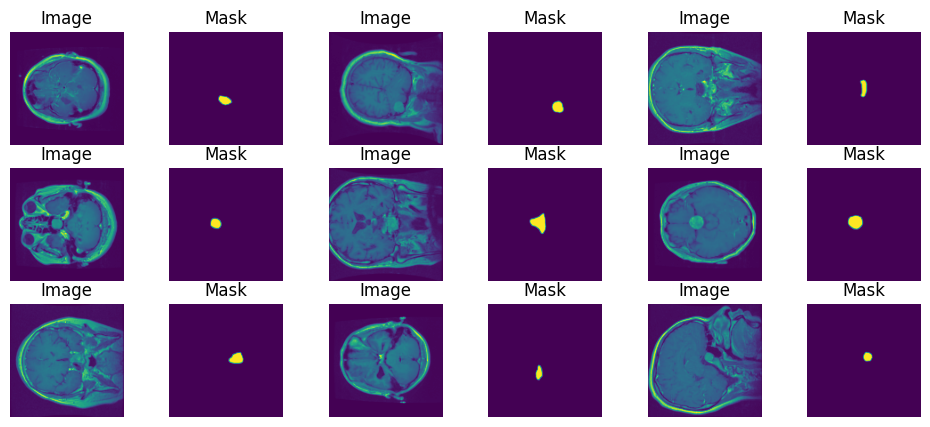

In [ ]:
plt.figure(figsize=(12, 5))
i=1
for idx in np.random.randint(3064, size=9):
  plt.subplot(3,6,i);i+=1
  plt.imshow( images[idx])
  plt.title("Image")
  plt.axis('off')
  plt.subplot(3,6,i);i+=1
  plt.imshow( masks[idx])
  plt.title("Mask")
  plt.axis('off')

## train test split

In [ ]:
input_shape = images[0].shape # input shape
input_shape

(128, 128, 1)

In [ ]:
x_train, x_test, y_train, y_test= train_test_split (images,masks,test_size=0.2, shuffle= True)
x_train.shape

(2451, 128, 128, 1)

In [ ]:
y_test.shape[0] # test set outpuutt shape

613

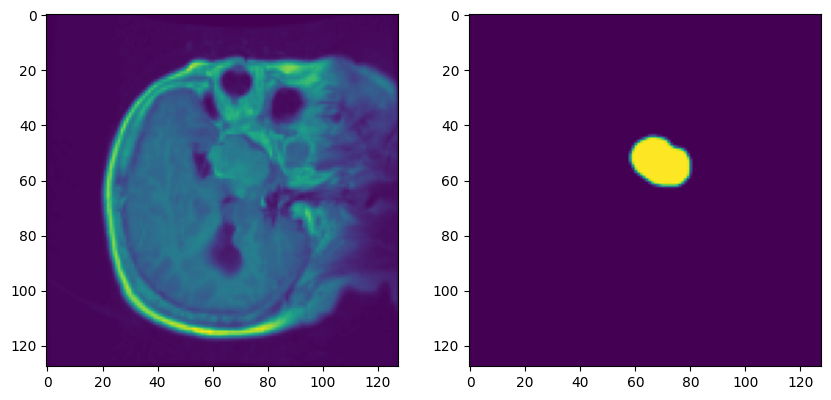

In [ ]:
fig, arr = plt.subplots(1,2,figsize=(10, 10))
arr[0].imshow(x_test[105])
arr[1].imshow(y_test[105])


## Data Augment

In [ ]:
#augment
x_train= np.append( x_train, [ np.fliplr(x) for x in  x_train], axis=0 )
y_train = np.append( y_train, [ np.fliplr(y) for y in  y_train], axis=0 )
x_train.shape, y_train.shape


((4902, 128, 128, 1), (4902, 128, 128, 1))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(brightness_range=(0.9,1.1),
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator()

## Unet

### Loss Function

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

### bce_dice_loss = binary_crossentropy_loss + dice_loss
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


### Convolution Model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

IMG_DIM = (128,128,1)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu", name=name+'_1')(input_tensor)

  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
             padding='same',activation="relu",name=name+'_2')(x)
  return x


inp = Input( shape=IMG_DIM )

d1 = conv2d_block( inp, 64, name="contraction_1")
p1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block( p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block( p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

out = Conv2D(1, (1,1), name="output", activation='sigmoid')(c4)

unet = Model( inp, out )
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 contraction_1_1 (Conv2D)       (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 contraction_1_2 (Conv2D)       (None, 128, 128, 64  36928       ['contraction_1_1[0][0]']        
                                )                                                             

In [ ]:
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

unet.compile(optimizer=optimizers.Adam(lr=1e-3),
             loss=bce_dice_loss, metrics=['accuracy'])

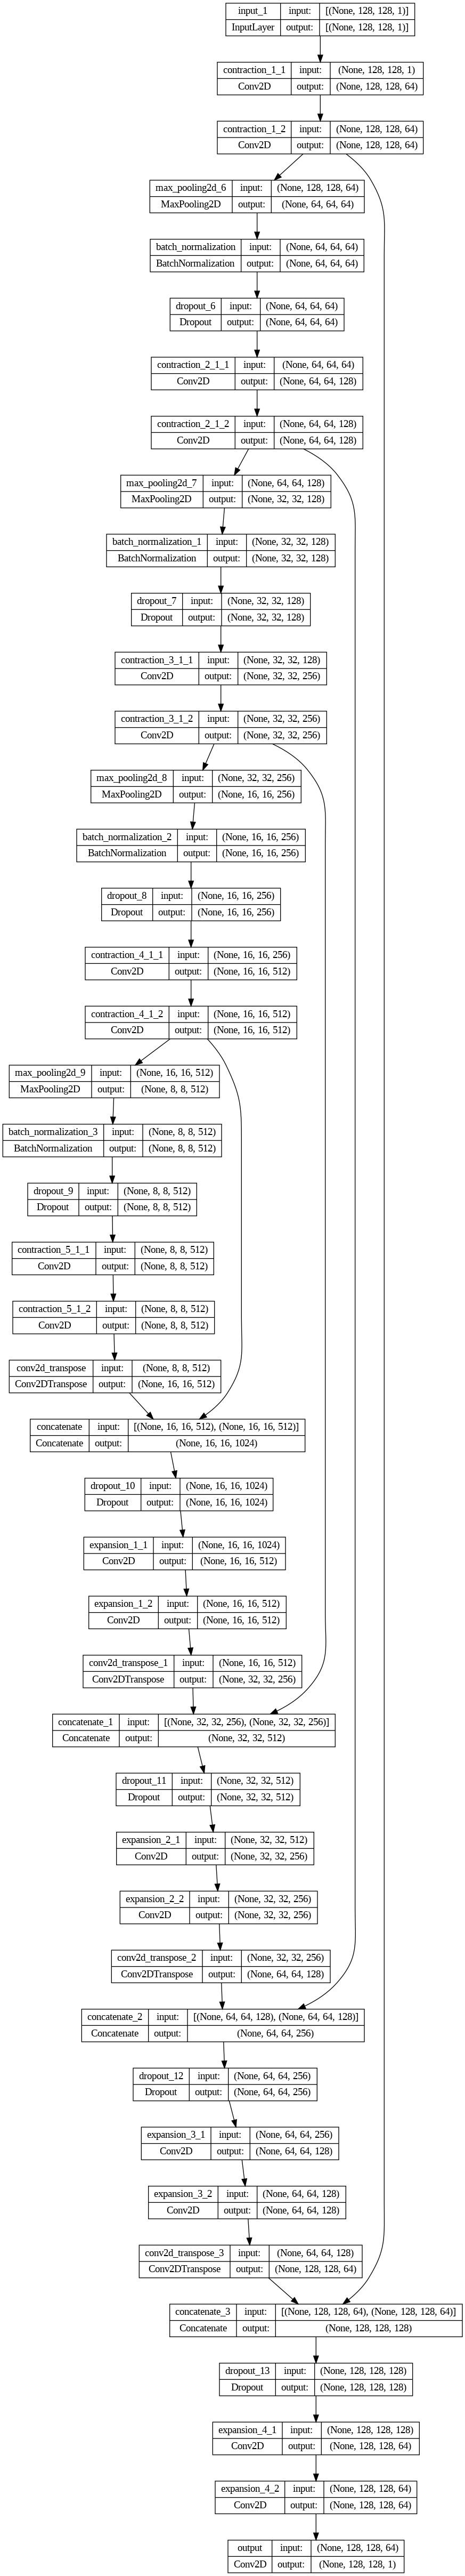

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(unet, to_file='model_segnet.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

#train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
#val_generator = val_datagen.flow(x_test, y_test, batch_size=32)

hist = unet.fit(x_train,y_train, validation_data=(x_test,y_test),epochs=5,batch_size=32)



Epoch 1/5
154/154 [==============================] - 106s 518ms/step - loss: 2.8038 - accuracy: 0.9556 - val_loss: 0.9445 - val_accuracy: 0.9741
Epoch 2/5
154/154 [==============================] - 75s 489ms/step - loss: 0.8098 - accuracy: 0.9666 - val_loss: 0.8659 - val_accuracy: 0.9561
Epoch 3/5
154/154 [==============================] - 75s 490ms/step - loss: 0.5919 - accuracy: 0.9750 - val_loss: 0.5464 - val_accuracy: 0.9770
Epoch 4/5
154/154 [==============================] - 75s 490ms/step - loss: 0.4746 - accuracy: 0.9780 - val_loss: 0.4741 - val_accuracy: 0.9780
Epoch 5/5
154/154 [==============================] - 76s 491ms/step - loss: 0.4125 - accuracy: 0.9794 - val_loss: 0.4566 - val_accuracy: 0.9796


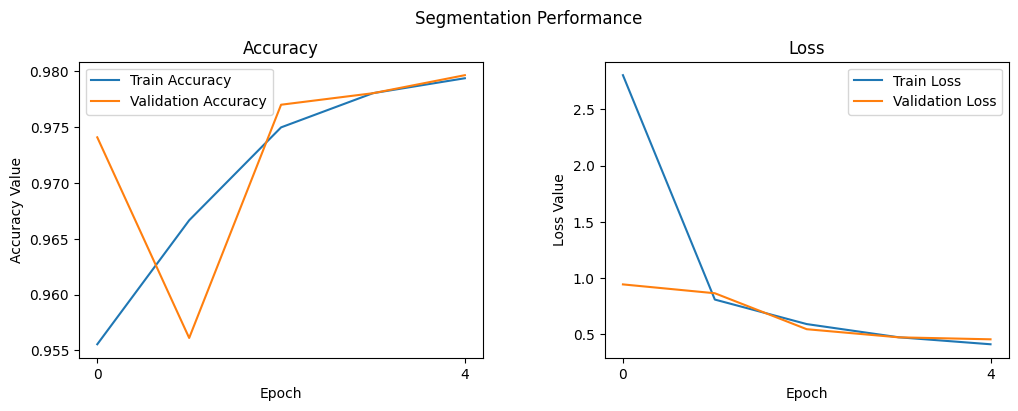

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Segmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,5))
ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 5, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 5, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## predict

20/20 [==============================] - 2s 120ms/step


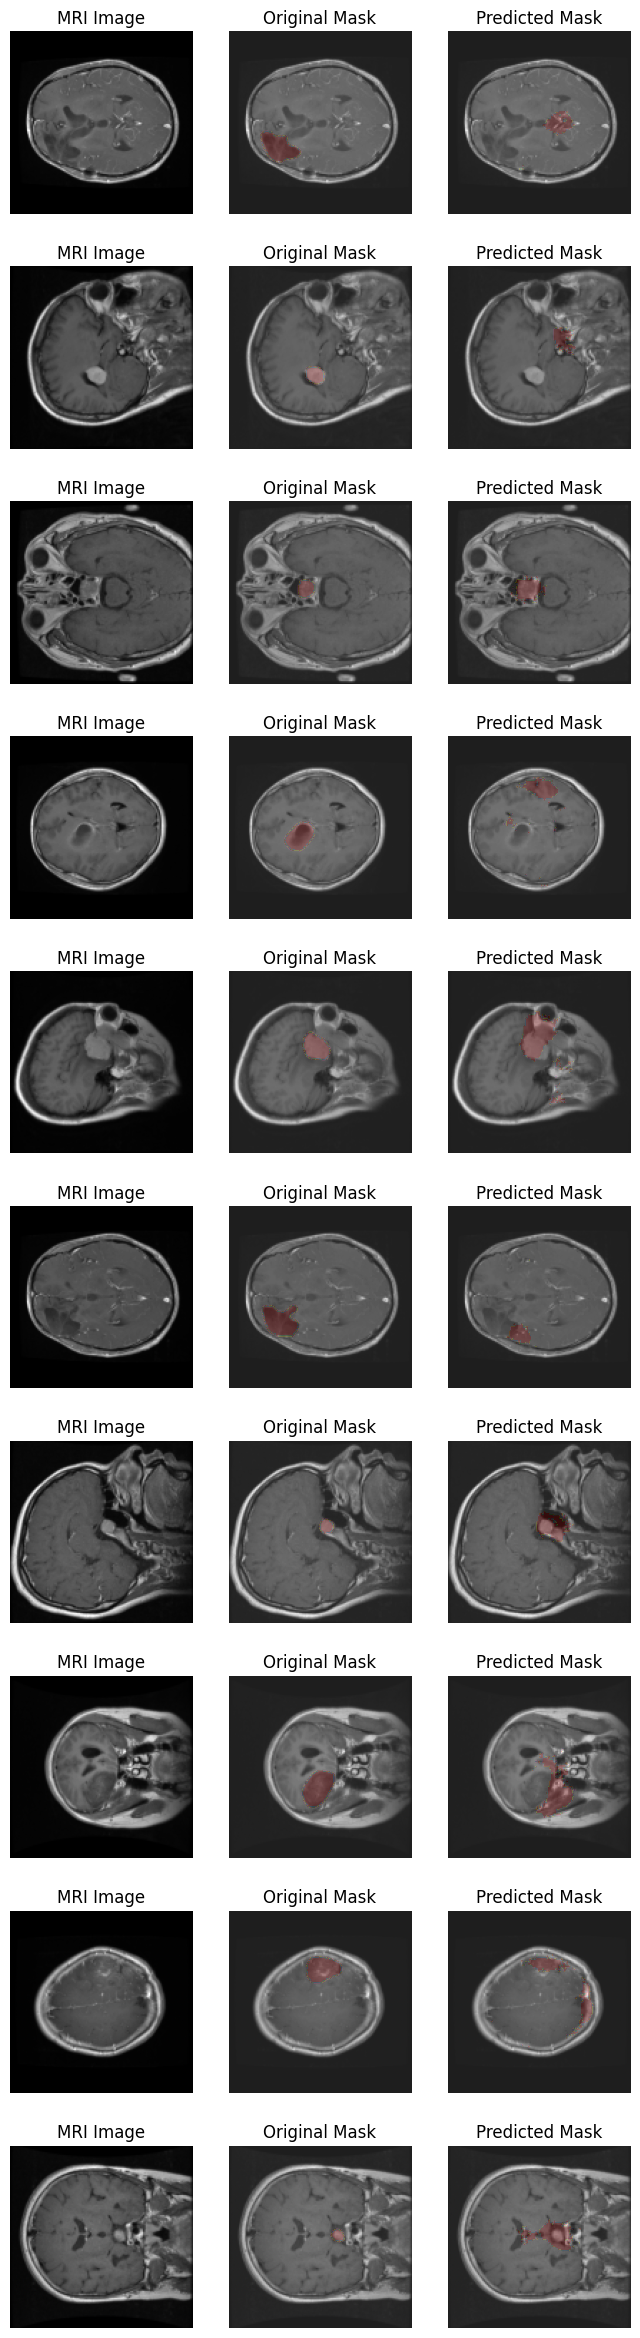

In [ ]:
THRESHOLD = 0.2
predicted_mask = (unet.predict(x_test)>THRESHOLD)*1

plt.figure(figsize=(8,30))
i=1;total=10
temp = np.ones_like(y_test[0] )
for idx in np.random.randint(0,high=x_test.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.title("MRI Image");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - y_test[idx], alpha=0.2, cmap='Set1' )
    plt.title("Original Mask");plt.axis('off')

    plt.subplot(total,3,i);i+=1
    plt.imshow( x_test[idx], cmap='gray' )
    plt.imshow( temp - predicted_mask[idx],  alpha=0.2, cmap='Set1' )
    plt.title("Predicted Mask");plt.axis('off')

# ***CNN**

## *train test split*

0


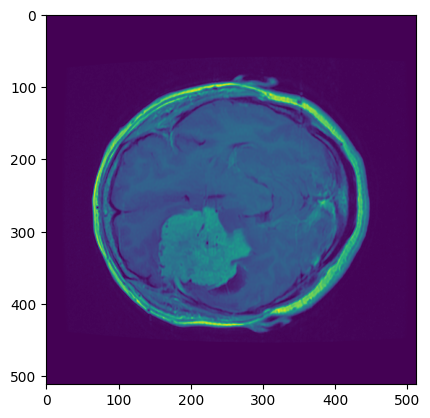

In [ ]:
img1=datalist[2]["cjdata"]["image"][()]
plt.imshow(img1)
print(int(datalist[2]["cjdata"]["label"][()])-1)

In [ ]:
x=[]
y=[]

for i in range(total_image):
    img=datalist[i]["cjdata"]["image"][()]

    if img.shape==(512,512):
       img=np.expand_dims(img,axis=0)
       x.append(img)

       label=int(datalist[i]["cjdata"]["label"][()])-1
       y.append(label)



x=np.array(x).reshape(-1,512,512,1)
y=np.array(y)

print(x.shape)
print(y.shape)


(997, 512, 512, 1)
(997,)


In [ ]:
trainx, testx, trainy, testy= train_test_split(x, y, test_size=0.2, shuffle=True)

print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(797, 512, 512, 1)
(200, 512, 512, 1)
(797,)
(200,)


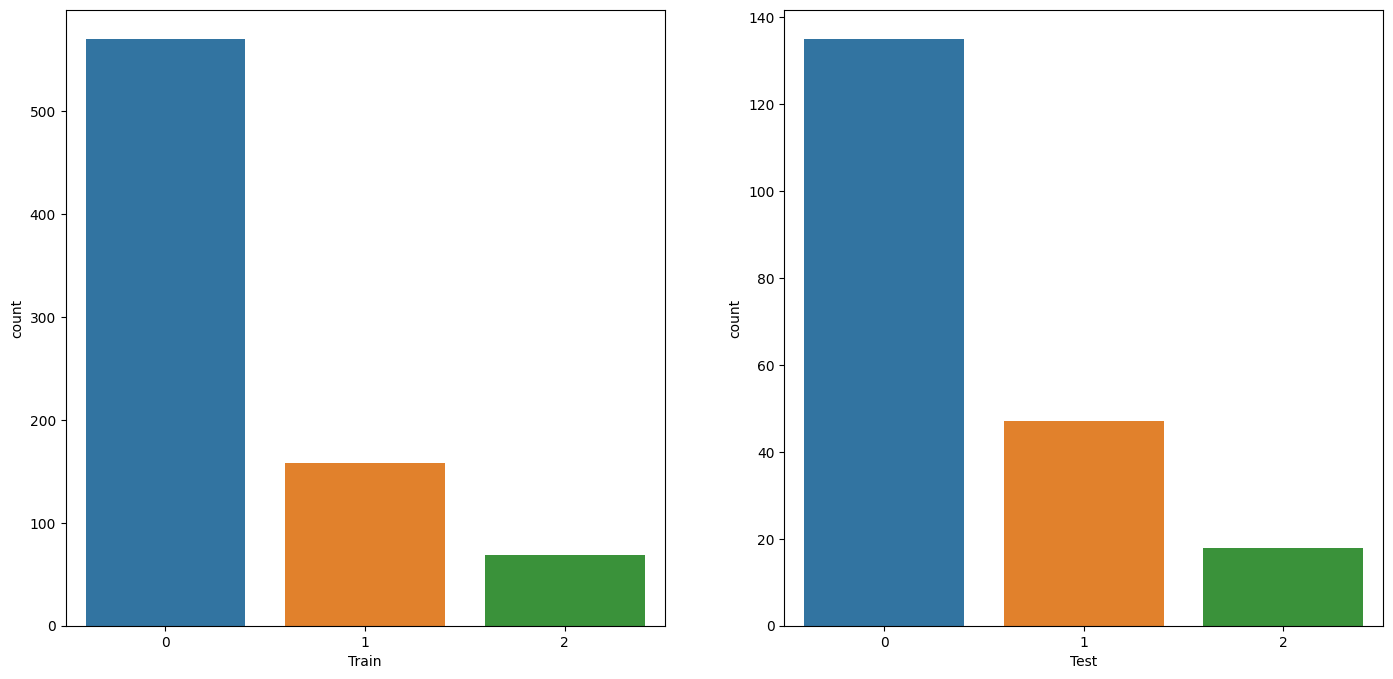

In [ ]:
import seaborn as sns
#'0': 'meningioma ', '1': 'glioma ', '2': 'pituitary tumor'
clases=['meningioma', 'glioma','pituitary tumor']
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([trainy, testy]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [ ]:
print(testy)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(trainy)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [ ]:
print(testx)

[[[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [1]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [1]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [1]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  ...

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]

  [[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[0]
   [0]
   [0]
   ...
   [0]
   [0]
   [0]

## Convolution Models

## 14 layers

In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, (5,5), activation='relu', input_shape=(512,512,1)),
    tf.keras.layers.MaxPool2D(pool_size = (5,5)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (3,3)),
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])
model1.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
r1=model1.fit(trainx,
          trainy,
          epochs=5,
          batch_size=32,
          verbose=1,
          validation_data=(testx,testy),
          shuffle=False
          )

Epoch 1/5
25/25 [==============================] - 16s 83ms/step - loss: 14.6135 - accuracy: 0.5609 - val_loss: 1.3529 - val_accuracy: 0.6950
Epoch 2/5
25/25 [==============================] - 1s 41ms/step - loss: 1.4984 - accuracy: 0.6324 - val_loss: 0.6691 - val_accuracy: 0.7200
Epoch 3/5
25/25 [==============================] - 1s 45ms/step - loss: 0.9234 - accuracy: 0.6512 - val_loss: 0.6455 - val_accuracy: 0.7150
Epoch 4/5
25/25 [==============================] - 1s 44ms/step - loss: 0.8175 - accuracy: 0.6939 - val_loss: 0.6524 - val_accuracy: 0.7300
Epoch 5/5
25/25 [==============================] - 1s 40ms/step - loss: 0.7186 - accuracy: 0.7139 - val_loss: 0.6033 - val_accuracy: 0.7500


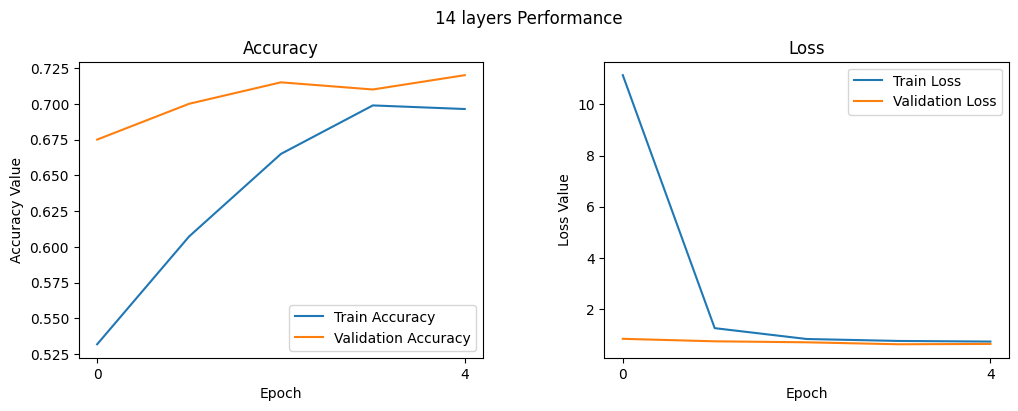

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('14 layers Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,5))
ax1.plot(epoch_list, r1.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, r1.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 5, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, r1.history['loss'], label='Train Loss')
ax2.plot(epoch_list, r1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 5, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### predict

In [ ]:
pred=model1.predict(testx)
Y_pred = np.argmax(pred, 1)

7/7 [==============================] - 17s 2s/step


### confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score
results = confusion_matrix(testy,Y_pred)
print('Confusion Matrix :')
print(results)
print('Accuracy Score :',accuracy_score(testy,Y_pred))
print('Report : ')
print(classification_report(testy,Y_pred))


Confusion Matrix :
[[136   2   1]
 [ 43   0   0]
 [ 10   0   8]]
Accuracy Score : 0.72
Report : 
              precision    recall  f1-score   support

           0       0.72      0.98      0.83       139
           1       0.00      0.00      0.00        43
           2       0.89      0.44      0.59        18

    accuracy                           0.72       200
   macro avg       0.54      0.47      0.47       200
weighted avg       0.58      0.72      0.63       200



[Text(0, 0.5, 'Meningioma'), Text(0, 1.5, 'Glioma'), Text(0, 2.5, 'Pituitary')]

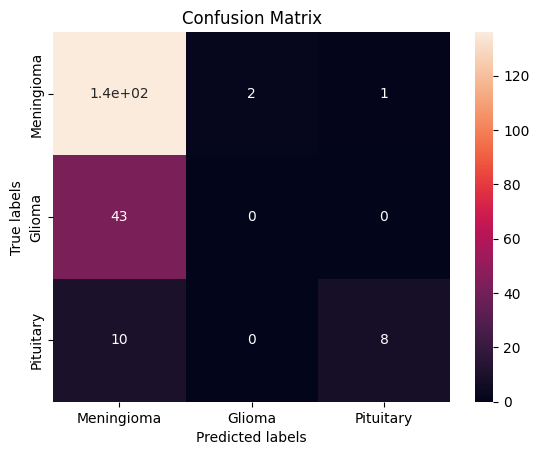

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
ax= plt.subplot()
cm=confusion_matrix(testy, Y_pred)
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Meningioma', 'Glioma', 'Pituitary']); ax.yaxis.set_ticklabels(['Meningioma', 'Glioma', 'Pituitary'])

## 23 layers(best model)

In [ ]:
ini_input=keras.Input(shape=(512,512,1),name="image")

x1=layers.Conv2D(64,(22,22),strides=2)(ini_input)
x1=layers.MaxPooling2D((4,4))(x1)
x1=layers.BatchNormalization()(x1)

x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
x2=layers.MaxPooling2D((2,2))(x2)
x2=layers.BatchNormalization()(x2)

x3=layers.Conv2D(256,(7,7),strides=2,padding="same")(x2)
x3=layers.MaxPooling2D((2,2))(x3)
x3=layers.BatchNormalization()(x3)

x4=layers.Conv2D(512,(3,3),strides=2,padding="same")(x3)
x4=layers.MaxPooling2D((2,2))(x4)
x4=layers.BatchNormalization()(x4)

x5=layers.GlobalAveragePooling2D()(x4)
x5=layers.Activation("relu")(x5)

x6=layers.Dense(1024,"relu")(x5)
x6=layers.BatchNormalization()(x6)

x7=layers.Dense(512,"relu")(x6)
x7=layers.BatchNormalization()(x7)

x8=layers.Dense(256,"relu")(x7)
x8=layers.BatchNormalization()(x8)

x8=layers.Dropout(.2)(x8)
x9=layers.Dense(3)(x5)
pred=layers.Activation("softmax")(x9)

model=keras.Model(inputs=ini_input,outputs=pred)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [ ]:
es = EarlyStopping(
    monitor='val_accuracy',
    mode='max'
)

In [ ]:
r=model.fit(trainx,
          trainy,
          epochs=50,
          batch_size=32,
          verbose=1,
          validation_data=(testx,testy),
          shuffle=False
          )

Epoch 1/50
25/25 [==============================] - 9s 140ms/step - loss: 0.9121 - accuracy: 0.6474 - val_loss: 15.3515 - val_accuracy: 0.7450
Epoch 2/50
25/25 [==============================] - 3s 122ms/step - loss: 0.5418 - accuracy: 0.7829 - val_loss: 1.8353 - val_accuracy: 0.6950
Epoch 3/50
25/25 [==============================] - 3s 126ms/step - loss: 0.4448 - accuracy: 0.8206 - val_loss: 1.5816 - val_accuracy: 0.7450
Epoch 4/50
25/25 [==============================] - 3s 123ms/step - loss: 0.3668 - accuracy: 0.8595 - val_loss: 2.2090 - val_accuracy: 0.7050
Epoch 5/50
25/25 [==============================] - 3s 123ms/step - loss: 0.2938 - accuracy: 0.8908 - val_loss: 0.9977 - val_accuracy: 0.7650
Epoch 6/50
25/25 [==============================] - 3s 124ms/step - loss: 0.2050 - accuracy: 0.9348 - val_loss: 0.8535 - val_accuracy: 0.7800
Epoch 7/50
25/25 [==============================] - 3s 126ms/step - loss: 0.1654 - accuracy: 0.9486 - val_loss: 0.8709 - val_accuracy: 0.7800
Epoch

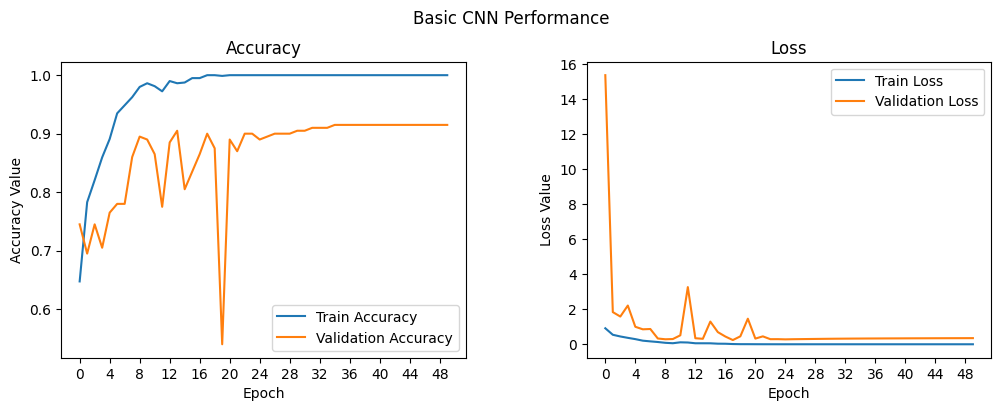

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,50))
ax1.plot(epoch_list, r.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, r.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 50, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, r.history['loss'], label='Train Loss')
ax2.plot(epoch_list, r.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 50, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### predict

In [ ]:
pred=model.predict(testx)
Y_pred = np.argmax(pred, 1)

Y_pred.shape

testy.shape

7/7 [==============================] - 2s 100ms/step


(200,)

In [ ]:
Y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
testy

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0,
       2, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 0, 1, 2, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       1, 0])

### visualize model

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 11.8 MB/s eta 0:00:00


In [ ]:
import visualkeras

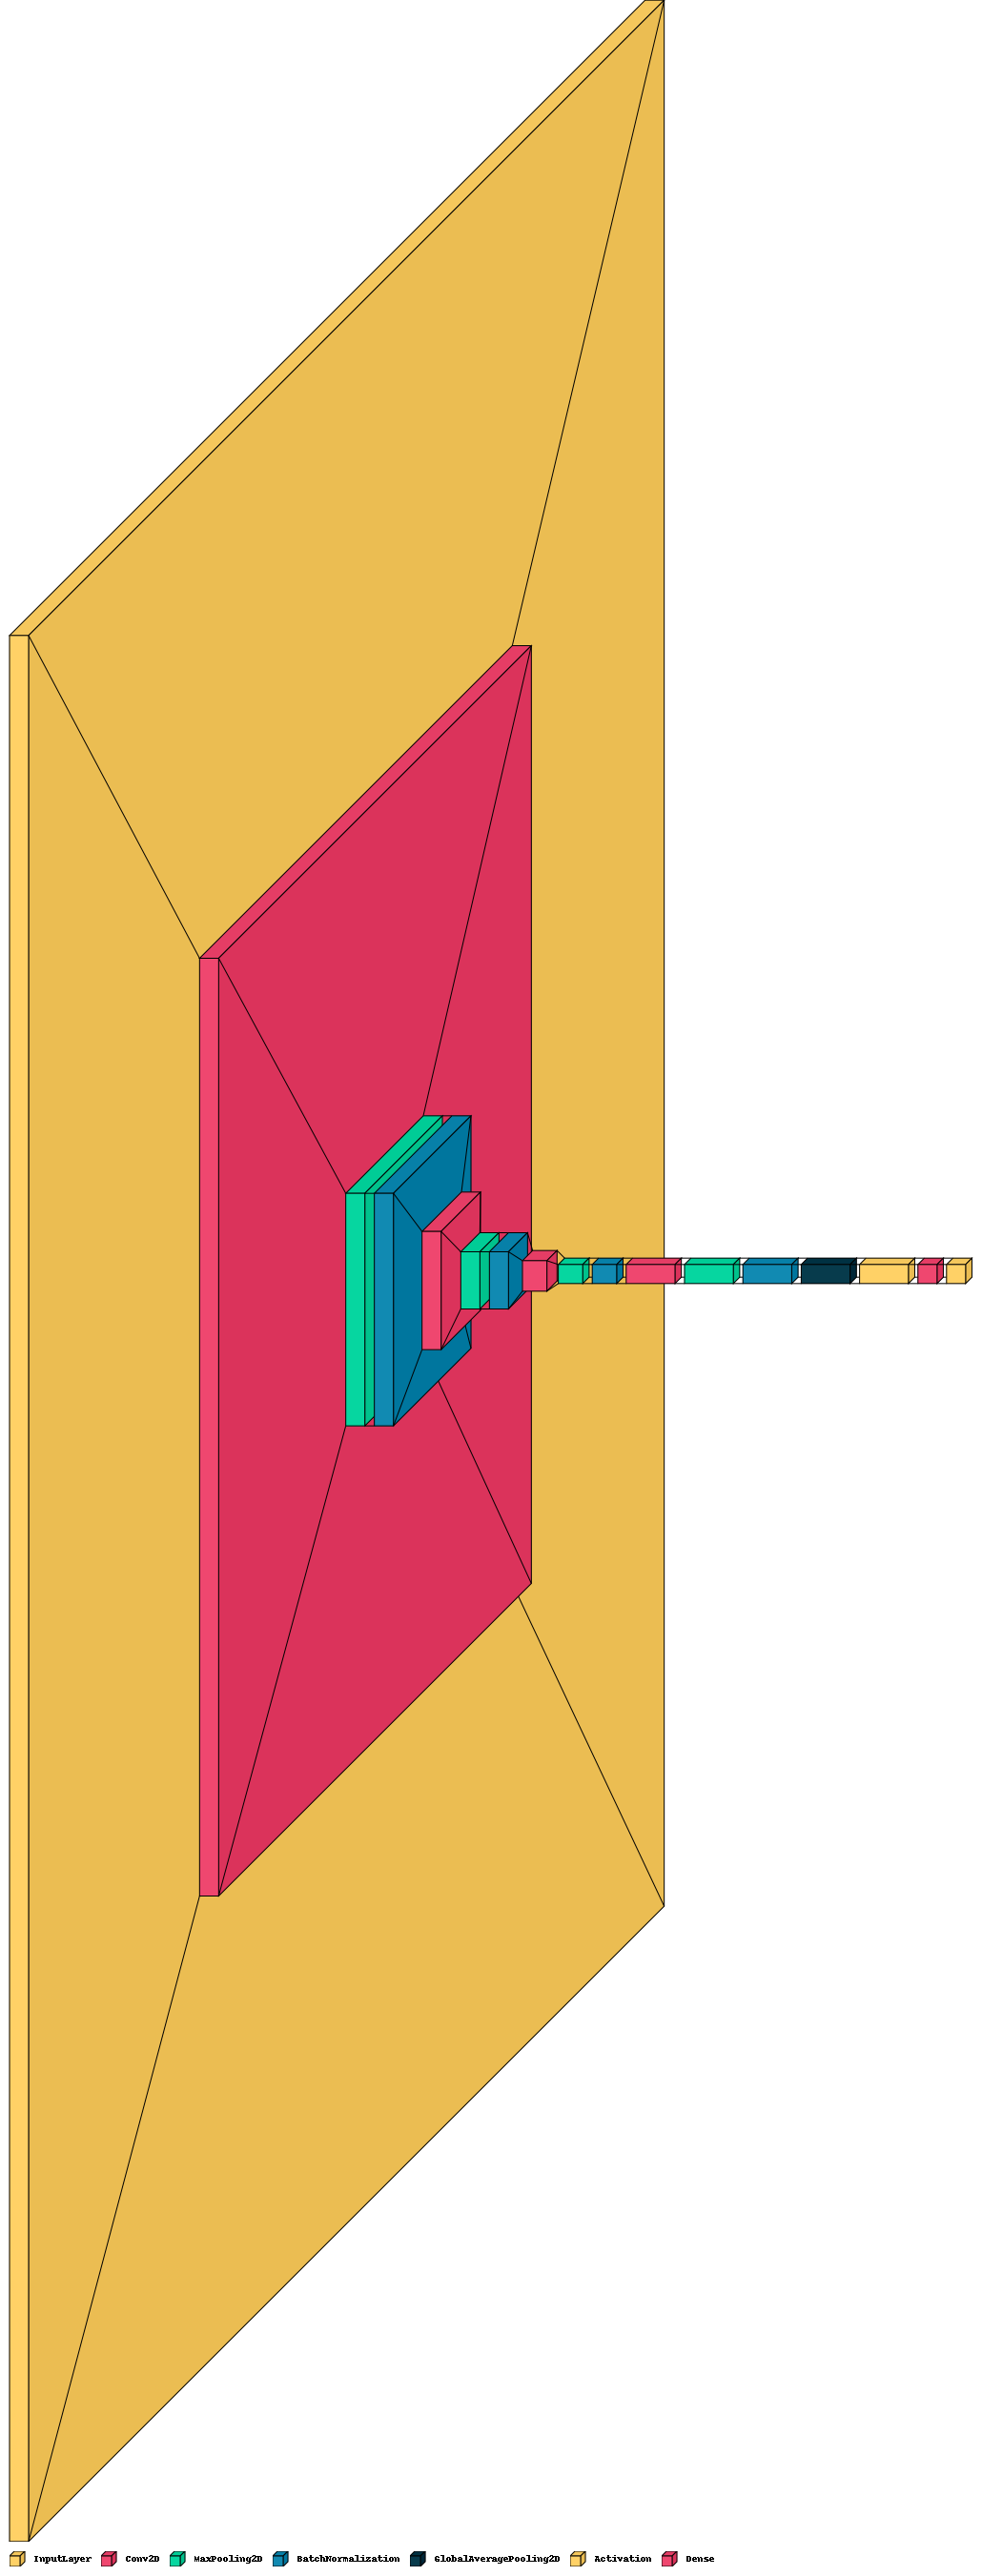

In [ ]:
from PIL import ImageFont
visualkeras.layered_view(model, to_file='model_architecture.png', legend=True )

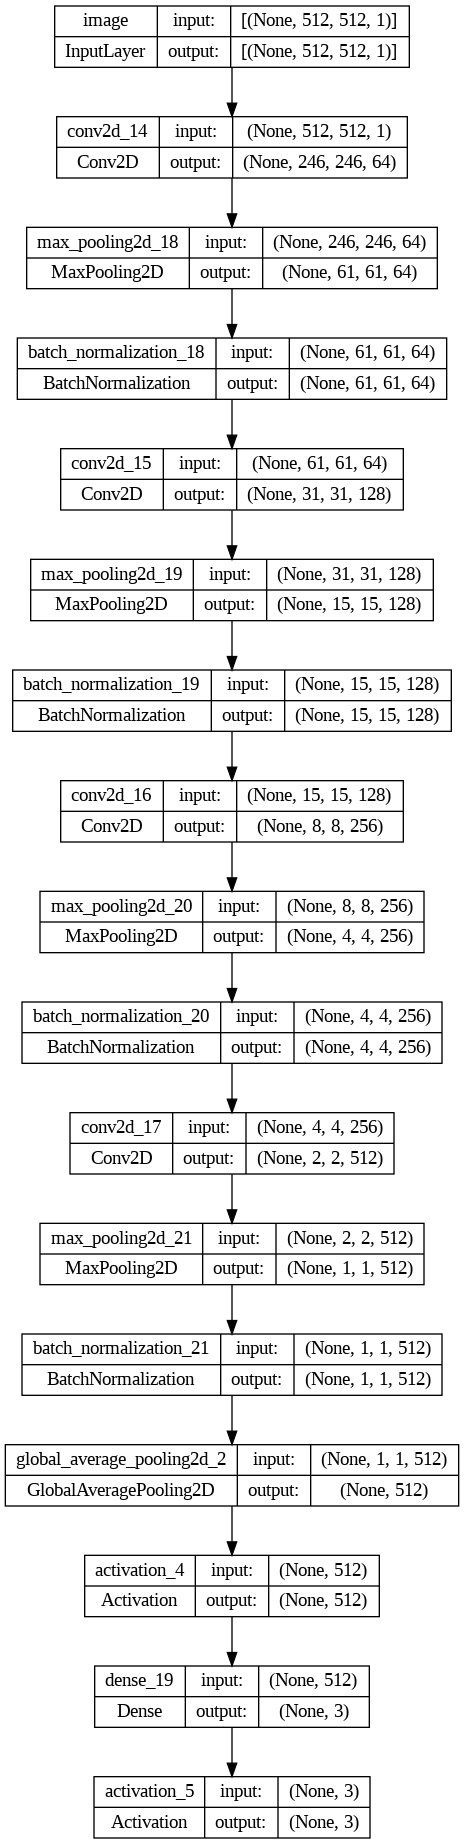

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_23.png', show_shapes=True, show_layer_names=True)

### confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
print('Classification Report')
target_names = ['Meningioma', 'Glioma', 'Pituitary']
print(classification_report(testy, Y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

  Meningioma       1.00      0.20      0.33       148
      Glioma       0.63      1.00      0.77       285
   Pituitary       0.87      0.63      0.73       177

    accuracy                           0.70       610
   macro avg       0.83      0.61      0.61       610
weighted avg       0.79      0.70      0.65       610



Confusion Matrix :
[[ 29 103  16]
 [  0 284   1]
 [  0  66 111]]
Accuracy Score : 0.6950819672131148
Report : 
              precision    recall  f1-score   support

           0       1.00      0.20      0.33       148
           1       0.63      1.00      0.77       285
           2       0.87      0.63      0.73       177

    accuracy                           0.70       610
   macro avg       0.83      0.61      0.61       610
weighted avg       0.79      0.70      0.65       610



<Axes: >

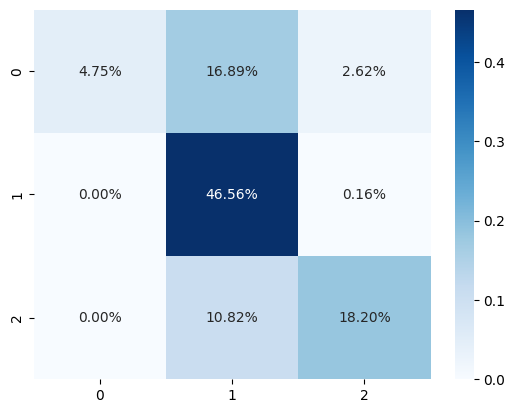

In [ ]:
from sklearn.metrics import accuracy_score
results = confusion_matrix(testy,Y_pred)
print('Confusion Matrix :')
print(results)
print('Accuracy Score :',accuracy_score(testy,Y_pred))
print('Report : ')
print(classification_report(testy,Y_pred))

sns.heatmap(results/np.sum(results), annot=True,
            fmt='.2%', cmap='Blues')

Text(113.9222222222222, 0.5, 'True Values')

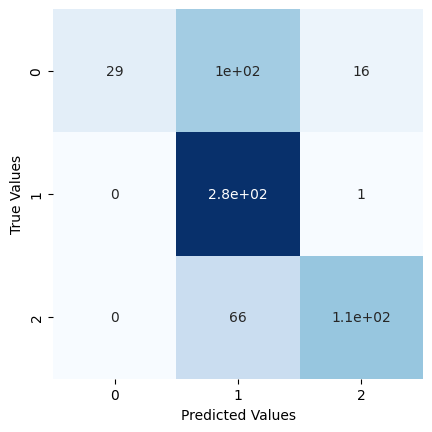

In [ ]:
import seaborn as sns
cm=confusion_matrix(testy, Y_pred)
sns.heatmap(cm, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(testy, Y_pred))

Confusion Matrix
[[ 29 103  16]
 [  0 284   1]
 [  0  66 111]]


[Text(0, 0.5, 'Meningioma'), Text(0, 1.5, 'Glioma'), Text(0, 2.5, 'Pituitary')]

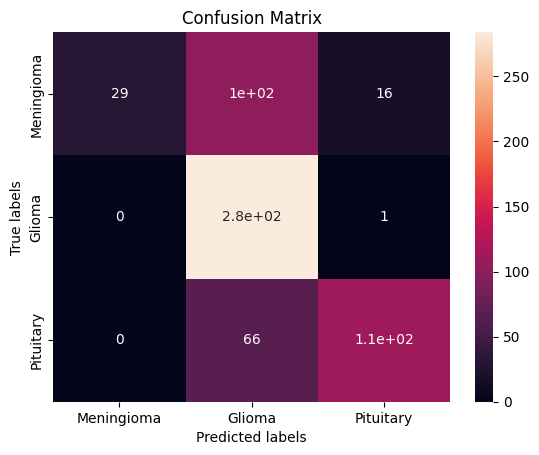

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Meningioma', 'Glioma', 'Pituitary']); ax.yaxis.set_ticklabels(['Meningioma', 'Glioma', 'Pituitary'])


# ***transfer learning**

## preparing data

### convert to 3 channel

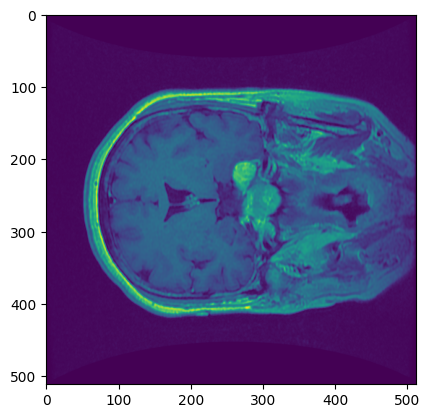

In [ ]:
plt.imshow(trainx[2])

In [ ]:
trainx3 = []
testx3 = []


for i in range(len(trainx)):

  x1 = trainx[i].shape[0]
  x2 = trainx[i].shape[1]
  image = tf.reshape(tf.broadcast_to(trainx[i], (x1, x2, 3)),  (x1, x2, 3))
  trainx3.append(image)


for i in range(len(testx)):

  x1 = testx[i].shape[0]
  x2 = testx[i].shape[1]
  image = tf.reshape(tf.broadcast_to(testx[i], (x1, x2, 3)),  (x1, x2, 3))
  testx3.append(image)



In [ ]:
trainx3=np.array(trainx3)

testx3=np.array(testx3)


In [ ]:
print(trainx3.shape)
print(testx3.shape)
print(trainy.shape)
print(testy.shape)

(797, 512, 512, 3)
(200, 512, 512, 3)
(797,)
(200,)


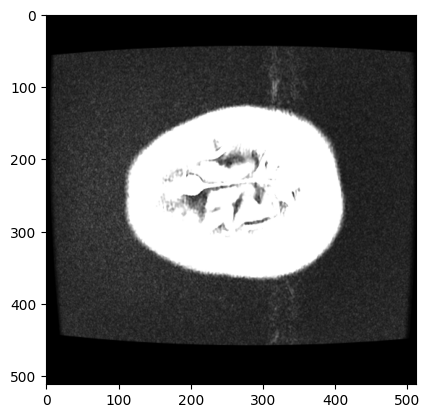

In [ ]:
plt.imshow(trainx3[2])

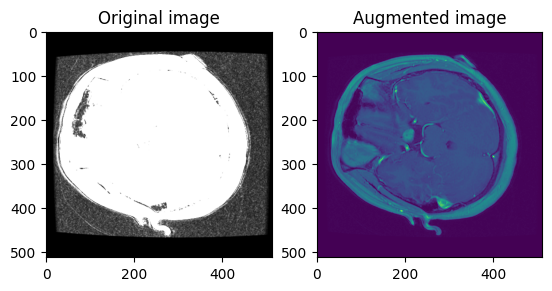

In [ ]:

fig = plt.figure()
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(trainx3[5])

plt.subplot(1,2,2)
plt.title('Augmented image')
plt.imshow(trainx[5])

## resnet50

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
base_Neural_Net= ResNet50(input_shape=(512,512,3), weights='imagenet', include_top=False)
model=Sequential()
model.add(base_Neural_Net)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',optimizer = "Adam", metrics= ['accuracy'])
hi=model.fit(trainx3 , trainy,validation_data=(testx3,testy), batch_size=5, epochs=2)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/2
160/160 [==============================] - 126s 334ms/step - loss: 0.9022 - accuracy: 0.6575 - val_loss: 89.7346 - val_accuracy: 0.7350
Epoch 2/2
160/160 [==============================] - 48s 297ms/step - loss: 0.8387 - accuracy: 0.6738 - val_loss: 39.3493 - val_accuracy: 0.7200


## resnetv2

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
resnet_v2 = InceptionResNetV2(include_top=False,
    weights='imagenet',
    input_shape=(512, 512, 3))

219055592/219055592 [==============================] - 2s 0us/step


In [ ]:
model = resnet_v2.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet_v2.input, outputs = model)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer = "Adam", metrics= ['accuracy'])

In [ ]:
his=model.fit(trainx3 , trainy,validation_data=(testx3,testy), batch_size=5, epochs=2)

Epoch 1/2
160/160 [==============================] - 206s 637ms/step - loss: 0.7799 - accuracy: 0.6888 - val_loss: 2.0020 - val_accuracy: 0.2800
Epoch 2/2
160/160 [==============================] - 94s 590ms/step - loss: 0.6961 - accuracy: 0.7215 - val_loss: 14.8587 - val_accuracy: 0.7500


##efficinetB0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(512,512,3))
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)


In [ ]:
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

hist=model.fit(trainx3 , trainy,validation_data=(testx3,testy), batch_size=5, epochs=2)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 512, 512, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 512, 512, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

## vgg16

In [ ]:

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
conv = VGG16(input_shape= (512,512,3),weights='imagenet',include_top=False)






for layer in conv.layers:
    layer.trainable = False


x = conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
x=  Dropout(.2)(x)
pred = Dense(3,activation='softmax')(x)
model = Model(inputs = conv.input,outputs=pred)


model.summary()

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(trainx3 , trainy,validation_data=(testx3,testy), batch_size=5, epochs=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     